# **Ali Arshad**

# **Physics-Informed Neural Networks (PINNs)**

In [ ]:
%reset -f

Consider the Black-Shole equation for illiquid market \cite{gulen2022frechet} on spatial domain, $\mathcal{D}=[0,20]$ and time $t\in[0,0.25]$:
\begin{align}
    \begin{cases}
        \frac{\partial V}{\partial t} - \frac{\sigma^2 S^2}{2(1-\rho S \frac{\partial^2 V}{\partial S^2})^2} \frac{\partial^2 V}{\partial S^2}= 0 & (t,S)\in[0,0.25)\times(0,20) \\
        V(0.25,S) = max\{S-E,0\} &S\in(0,20)\\
        V(t,0)=0 &t\in[0,0.25) \\
        V(t,20)=Ee^{-rt} &t\in[0,0.25)
    \end{cases}
\end{align}

where $S, T=20, \sigma, and \rho$ stand for the stock price, the maturity date, the asset volatility, and a parameter measuring the market liquidity with $0<\rho<1$, respectively.

We solve this with parameters: $\sigma=0.2, \rho=0.02, r=0.03, E=10.$

In [ ]:
from time import time

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
sigma=tf.constant(0.2,dtype=DTYPE)
roo=tf.constant(0.02,dtype=DTYPE)
r=tf.constant(0.03,dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
k=10 #Known as E in the problem stated above.

# Define initial condition
def fun_u_0(x):
  if x-k>0:
    return x-k
  else:
    return 0.0

# Define boundary condition
def fun_u_b1(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def fun_u_b2(t,x):
    return k*tf.exp(-r*t)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t - (0.5*(sigma**2)*(x**2)*u_xx)/(1-roo*x*u_xx)**2

In [ ]:
# Set number of data points
N_0 = 800
N_b = 50
N_r = 15000#N_0*N_b

# Set boundary
tmin = 0.
tmax = 0.25
xmin = 0.
xmax = 20.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
ui=[]
for xi in x_0:
  if fun_u_0(xi)!=0:
    ui.append(fun_u_0(xi).numpy()[0])
  else:
    ui.append(fun_u_0(xi))
tensor = tf.convert_to_tensor(ui)

u_0 = tf.expand_dims(tensor, axis=1)


In [ ]:
# Boundary data
t_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b1 = tf.ones([N_b,1])*lb[1]
t_b2 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b2 = tf.ones([N_b,1])*ub[1]
X_b1 = tf.concat([t_b1, x_b1], axis=1)
X_b2 = tf.concat([t_b2, x_b2], axis=1)

In [ ]:
# x_b1,x_b2

In [ ]:
# Evaluate boundary condition at (t_b,x_b)
u_b1 = fun_u_b1(t_b1, x_b1)
u_b2 = fun_u_b2(t_b2, x_b2)

In [ ]:
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b1, X_b2]
u_data = [u_0, u_b1, u_b2]

In [ ]:
# x_0.shape,X_0.shape, u_0.shape, x_b.shape, X_b.shape, u_b.shape

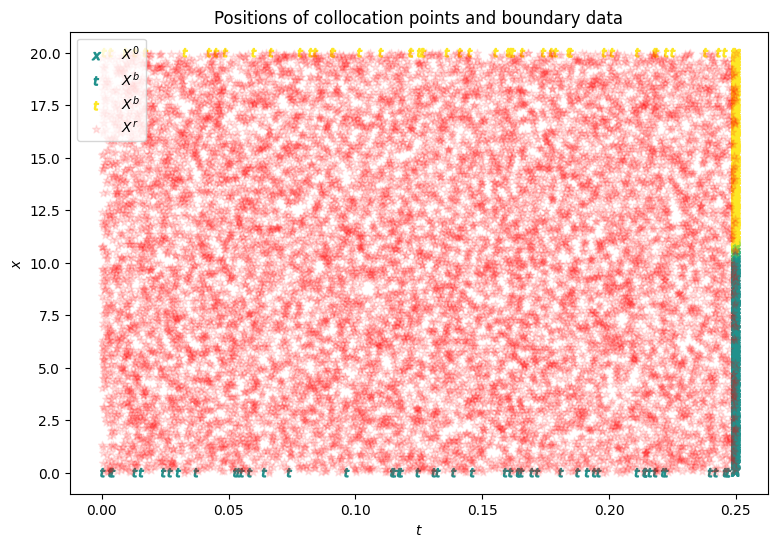

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='$x$', vmin=-1, vmax=1,label=f'$X^0$')
plt.scatter(t_b1, x_b1, c=u_b1, marker='$t$', vmin=-1, vmax=1,label=f'$X^b$')
plt.scatter(t_b2, x_b2, c=u_b2, marker='$t$', vmin=-1, vmax=1,label=f'$X^b$')
plt.scatter(t_r, x_r, c='r', marker='*', alpha=0.1,label=f'$X^r$')
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
plt.legend()
plt.show()
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub, output_dim=1, num_hidden_layers=5, num_neurons_per_layer=20,
                 activation='tanh',kernel_initializer='glorot_normal', **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [ ]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss

    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            #tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t - (0.5*(sigma**2)*(x**2)*u_xx)/(1-roo*x*u_xx)**2

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [ ]:
0.001,.0001,5e-4

(0.001, 0.0001, 0.0005)

In [ ]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,2))

# Initilize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
mode = 'TFoptimizer'
#mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,5000],[0.01,.001,0.001])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=5001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                            method='BFGS'
                             ,options={'maxiter': 50000})#,'ftol':1e-200,'gtol':1e-200})#,'eps':1e10})
                                    #    ,
                                    #  'maxfun': 10000,
                                    #  'maxcor': 10000,
                                    #  'maxls': 10000,
                                    #  'eps': 1e10,
                                    #  'gtol':1e-200
                                    #  ,'ftol': 1e-200})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'pinn__neural_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


It 00000: loss = 1.24704033e+02
It 00010: loss = 4.95872383e+01
It 00020: loss = 2.94130592e+01
It 00030: loss = 1.91463013e+01
It 00040: loss = 6.26716805e+00
It 00050: loss = 1.27772546e+00
It 00060: loss = 5.39149404e-01
It 00070: loss = 1.96905941e-01
It 00080: loss = 1.78697318e-01
It 00090: loss = 1.38017565e-01
It 00100: loss = 1.10663600e-01
It 00110: loss = 9.02598947e-02
It 00120: loss = 7.81071112e-02
It 00130: loss = 6.97223321e-02
It 00140: loss = 6.39796779e-02
It 00150: loss = 6.03182279e-02
It 00160: loss = 2.65565366e-01
It 00170: loss = 5.93124889e-02
It 00180: loss = 5.40306494e-02
It 00190: loss = 5.45675084e-02
It 00200: loss = 5.31700477e-02
It 00210: loss = 4.91331182e-02
It 00220: loss = 4.82591577e-02
It 00230: loss = 4.69095744e-02
It 00240: loss = 4.59388718e-02
It 00250: loss = 4.50779200e-02
It 00260: loss = 4.42434177e-02
It 00270: loss = 4.34713215e-02
It 00280: loss = 4.27219570e-02
It 00290: loss = 4.19949144e-02
It 00300: loss = 4.12874036e-02
It 00310

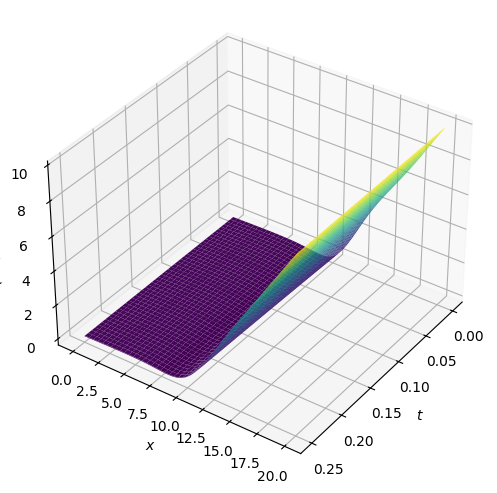

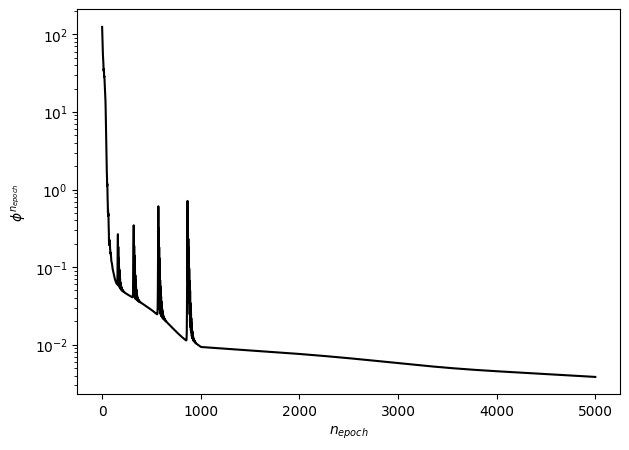

In [ ]:
solver.plot_solution();
solver.plot_loss_history();

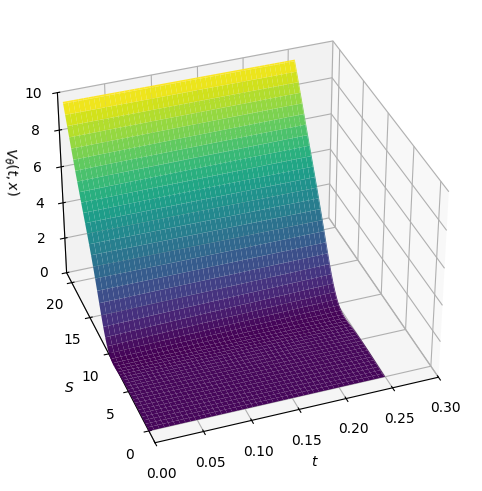

In [ ]:
def plot_solution():
    N = 600
    tspace = np.linspace(lb[0], ub[0], N+1)
    xspace = np.linspace(lb[1], ub[1], N+1)
    T, X = np.meshgrid(tspace, xspace)
    Xgrid = np.vstack([T.flatten(),X.flatten()]).T
    upred = model(tf.cast(Xgrid,DTYPE))
    U = upred.numpy().reshape(N+1,N+1)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, U, cmap='viridis')#, **kwargs)
    ax.set_zlim(0, k)
    #plt.xticks([0,0.1,0.2,0.3])
    plt.yticks(np.arange(0, 21, 5))
    plt.xlim(0,0.3)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$S$')
    ax.set_zlabel('$V_\\theta(t,x)$')
    ax.view_init(35,250)
    return ax
plot_solution();